In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import os
import glob
from collections import defaultdict

In [24]:
def read_lightcurve_file(filename):
    """
    Read the lightcurve file and extract header parameters and data
    """
    data = {}
    
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    # Extract header info
    header_params = {}
    data_lines = []
    
    for line in lines:
        if line.startswith('#'):
            # Parse header lines
            if '=' in line:
                key_value = line[1:].strip().split('=')
                if len(key_value) == 2:
                    key = key_value[0].strip()
                    value = key_value[1].strip()
                    header_params[key] = value
        else:
            # Only add non-empty lines that don't start with #
            if line.strip() and not line.strip().startswith('#'):
                data_lines.append(line.strip())
    
    # Convert data to numpy array
    if data_lines:
        try:
            data_array = np.genfromtxt(data_lines)
            
            # Check if we have enough columns
            if data_array.ndim == 1:
                # Single row case
                data_array = data_array.reshape(1, -1)
            
            # Define column names based on your description
            column_names = ['Simulation_time', 'measured_relative_flux', 'measured_relative_flux_error', 
                           'true_relative_flux', 'true_relative_flux_error', 'observatory_code', 
                           'saturation_flag', 'best_single_lens_fit', 'parallax_shift_t', 'parallax_shift_u',
                           'BJD', 'source_x', 'source_y', 'lens1_x', 'lens1_y', 'lens2_x', 'lens2_y']
            
            # Create dictionary with column data
            for i, col_name in enumerate(column_names):
                if i < data_array.shape[1]:
                    data[col_name] = data_array[:, i]
                else:
                    data[col_name] = np.array([])
                    
        except Exception as e:
            print(f"Error parsing data from {filename}: {e}")
            data = None
    else:
        data = None
    
    return header_params, data

In [25]:
def extract_and_process_tar_files():
    """
    Extract all tar.gz files and process the lightcurve files
    """
    # Find all tar.gz files in current directory 
    tar_files = glob.glob('OMPLDG_croin_cassan_*.tar.gz') #glob helps find files whose names have a specific pattern
    
    # If no files found with correct pattern, try the pattern from your error message
    if not tar_files:
        tar_files = glob.glob('OWPLOG_croin_cassan_*.tar.gz')
    
    if not tar_files:
        print("No tar files found! Looking for files in current directory:")
        print("Files in current directory:", os.listdir('.'))
        return {}
    
    print(f"Found {len(tar_files)} tar files to process") #number of tar files found
    all_parameters = {}
    
    for tar_file in tar_files:
        #print(f"Processing {tar_file}...")
        
        # Extract tar file
        with tarfile.open(tar_file, 'r:gz') as tar:
            # Get list of all files in tar
            file_list = tar.getnames()
            #print(f"  Files in archive: {file_list}")
            
            # Extract to a temporary directory
            extract_dir = f"temp_{tar_file.replace('.tar.gz', '')}"
            tar.extractall(extract_dir)
        
        # Find all files in the extracted directory (recursively)
        all_files = []
        for root, dirs, files in os.walk(extract_dir):
            for file in files:
                all_files.append(os.path.join(root, file))
        
        print(f"  Found {len(all_files)} total files in extracted directory")
        
        file_parameters = []
        
        for file_path in all_files:
            # Try to process any file that might be a lightcurve
            try:
                header_params, data = read_lightcurve_file(file_path)
                if data is not None and len(data) > 0 and 'Simulation_time' in data:
                    # Calculate some basic statistics for this lightcurve
                    stats = {
                        'filename': os.path.basename(file_path),
                        'header_params': header_params,
                        'data_stats': {
                            'num_points': len(data['Simulation_time']),
                            'time_range': [np.min(data['Simulation_time']), np.max(data['Simulation_time'])],
                            'mean_measured_flux': np.mean(data['measured_relative_flux']),
                            'std_measured_flux': np.std(data['measured_relative_flux']),
                            'mean_true_flux': np.mean(data['true_relative_flux']),
                            'std_true_flux': np.std(data['true_relative_flux']),
                        },
                        'data': data  # Store the actual data for plotting
                    }
                    file_parameters.append(stats)
                    #print(f"    Successfully processed: {os.path.basename(file_path)} - {len(data['Simulation_time'])} data points")
            except Exception as e:
                # Skip files that can't be processed
                continue
        
        all_parameters[tar_file] = file_parameters
        #print(f"  Successfully processed {len(file_parameters)} lightcurves from {tar_file}")
        
        # Clean up extracted files
        import shutil
        shutil.rmtree(extract_dir)
    
    return all_parameters

In [26]:
def plot_parameter_distributions(all_parameters):
    """
    Plot distributions of ALL key microlensing parameters as requested
    """
    # Collect all parameters from all lightcurves
    all_best_fits = []
    all_parallax_t = []
    all_parallax_u = []
    all_observatory_codes = []
    all_saturation_flags = []
    all_source_x = []
    all_source_y = []
    all_lens1_x = []
    all_lens1_y = []
    all_lens2_x = []
    all_lens2_y = []
    all_flux_errors = []
    
    # Header parameters
    all_fs_values = []
    all_source_mags = []
    
    for tar_file, file_params_list in all_parameters.items():
        for file_params in file_params_list:
            data = file_params['data']
            header = file_params['header_params']
            
            # Collect data column parameters
            all_best_fits.extend(data['best_single_lens_fit'])
            all_parallax_t.extend(data['parallax_shift_t'])
            all_parallax_u.extend(data['parallax_shift_u'])
            all_observatory_codes.extend(data['observatory_code'])
            all_saturation_flags.extend(data['saturation_flag'])
            all_source_x.extend(data['source_x'])
            all_source_y.extend(data['source_y'])
            all_lens1_x.extend(data['lens1_x'])
            all_lens1_y.extend(data['lens1_y'])
            all_lens2_x.extend(data['lens2_x'])
            all_lens2_y.extend(data['lens2_y'])
            all_flux_errors.extend(data['measured_relative_flux_error'])
            
            # Collect header parameters
            if 'fs' in header:
                try:
                    all_fs_values.append(float(header['fs']))
                except:
                    pass
            if 'Obssrcmag' in header:
                try:
                    # Parse magnitude values (might be comma-separated)
                    mags = [float(x) for x in header['Obssrcmag'].split(',')]
                    all_source_mags.extend(mags)
                except:
                    pass
    
    # Create comprehensive plots
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Comprehensive Microlensing Parameter Distributions', fontsize=16)
    
    # Plot 1: Best single lens fit
    if all_best_fits:
        axes[0,0].hist(all_best_fits, bins=50, alpha=0.7, edgecolor='black')
        axes[0,0].set_xlabel('Best Single Lens Fit')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_title('Single Lens Fit Quality')
        axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Parallax shift t
    if all_parallax_t:
        axes[0,1].hist(all_parallax_t, bins=50, alpha=0.7, edgecolor='black', color='orange')
        axes[0,1].set_xlabel('Parallax Shift t')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].set_title('Parallax Shift (t-direction)')
        axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Parallax shift u
    if all_parallax_u:
        axes[0,2].hist(all_parallax_u, bins=50, alpha=0.7, edgecolor='black', color='green')
        axes[0,2].set_xlabel('Parallax Shift u')
        axes[0,2].set_ylabel('Frequency')
        axes[0,2].set_title('Parallax Shift (u-direction)')
        axes[0,2].grid(True, alpha=0.3)
    
    # Plot 4: Observatory codes
    if all_observatory_codes:
        observatory_names = ['W146', 'Z087', 'K213']
        code_counts = [all_observatory_codes.count(i) for i in range(3)]
        axes[0,3].bar(observatory_names, code_counts, alpha=0.7, color=['red', 'blue', 'green'])
        axes[0,3].set_xlabel('Observatory')
        axes[0,3].set_ylabel('Number of Observations')
        axes[0,3].set_title('Observatory Distribution')
        axes[0,3].grid(True, alpha=0.3)
    
    # Plot 5: Saturation flags
    if all_saturation_flags:
        sat_counts = [all_saturation_flags.count(0), all_saturation_flags.count(1)]
        axes[1,0].bar(['Not Saturated', 'Saturated'], sat_counts, alpha=0.7, color=['blue', 'red'])
        axes[1,0].set_xlabel('Saturation Status')
        axes[1,0].set_ylabel('Count')
        axes[1,0].set_title('Saturation Flag Distribution')
        axes[1,0].grid(True, alpha=0.3)
    
    # Plot 6: Source positions X
    if all_source_x:
        axes[1,1].hist(all_source_x, bins=50, alpha=0.7, edgecolor='black')
        axes[1,1].set_xlabel('Source X Position')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Source X Position Distribution')
        axes[1,1].grid(True, alpha=0.3)
    
    # Plot 7: Source positions Y
    if all_source_y:
        axes[1,2].hist(all_source_y, bins=50, alpha=0.7, edgecolor='black', color='orange')
        axes[1,2].set_xlabel('Source Y Position')
        axes[1,2].set_ylabel('Frequency')
        axes[1,2].set_title('Source Y Position Distribution')
        axes[1,2].grid(True, alpha=0.3)
    
    # Plot 8: Flux errors
    if all_flux_errors:
        axes[1,3].hist(all_flux_errors, bins=50, alpha=0.7, edgecolor='black', color='green')
        axes[1,3].set_xlabel('Measured Flux Error')
        axes[1,3].set_ylabel('Frequency')
        axes[1,3].set_title('Flux Error Distribution')
        axes[1,3].grid(True, alpha=0.3)
    
    # Plot 9-10: Lens1 positions
    if all_lens1_x:
        axes[2,0].hist(all_lens1_x, bins=50, alpha=0.7, edgecolor='black')
        axes[2,0].set_xlabel('Lens1 X Position')
        axes[2,0].set_ylabel('Frequency')
        axes[2,0].set_title('Lens1 X Position')
        axes[2,0].grid(True, alpha=0.3)
    
    if all_lens1_y:
        axes[2,1].hist(all_lens1_y, bins=50, alpha=0.7, edgecolor='black', color='orange')
        axes[2,1].set_xlabel('Lens1 Y Position')
        axes[2,1].set_ylabel('Frequency')
        axes[2,1].set_title('Lens1 Y Position')
        axes[2,1].grid(True, alpha=0.3)
    
    # Plot 11-12: Lens2 positions
    if all_lens2_x:
        axes[2,2].hist(all_lens2_x, bins=50, alpha=0.7, edgecolor='black', color='green')
        axes[2,2].set_xlabel('Lens2 X Position')
        axes[2,2].set_ylabel('Frequency')
        axes[2,2].set_title('Lens2 X Position')
        axes[2,2].grid(True, alpha=0.3)
    
    if all_lens2_y:
        axes[2,3].hist(all_lens2_y, bins=50, alpha=0.7, edgecolor='black', color='purple')
        axes[2,3].set_xlabel('Lens2 Y Position')
        axes[2,3].set_ylabel('Frequency')
        axes[2,3].set_title('Lens2 Y Position')
        axes[2,3].grid(True, alpha=0.3)
    
    # Plot 13: fs parameter
    if all_fs_values:
        axes[3,0].hist(all_fs_values, bins=30, alpha=0.7, edgecolor='black')
        axes[3,0].set_xlabel('fs values')
        axes[3,0].set_ylabel('Frequency')
        axes[3,0].set_title('Source Flux Fraction (fs)')
        axes[3,0].grid(True, alpha=0.3)
    
    # Plot 14: Source magnitudes
    if all_source_mags:
        axes[3,1].hist(all_source_mags, bins=30, alpha=0.7, edgecolor='black', color='orange')
        axes[3,1].set_xlabel('Source Magnitude')
        axes[3,1].set_ylabel('Frequency')
        axes[3,1].set_title('Source Magnitude Distribution')
        axes[3,1].grid(True, alpha=0.3)
    
    # Plot 15: Source position scatter
    if all_source_x and all_source_y:
        axes[3,2].scatter(all_source_x, all_source_y, alpha=0.5, s=1)
        axes[3,2].set_xlabel('Source X')
        axes[3,2].set_ylabel('Source Y')
        axes[3,2].set_title('Source Position Scatter')
        axes[3,2].grid(True, alpha=0.3)
    
    # Plot 16: Lens separation
    if all_lens1_x and all_lens1_y and all_lens2_x and all_lens2_y:
        separations = []
        for i in range(min(1000, len(all_lens1_x))):  # Limit for performance
            sep = np.sqrt((all_lens1_x[i]-all_lens2_x[i])**2 + (all_lens1_y[i]-all_lens2_y[i])**2)
            separations.append(sep)
        axes[3,3].hist(separations, bins=30, alpha=0.7, edgecolor='black', color='green')
        axes[3,3].set_xlabel('Lens Separation')
        axes[3,3].set_ylabel('Frequency')
        axes[3,3].set_title('Binary Lens Separation')
        axes[3,3].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(4):
        for j in range(4):
            if not axes[i,j].has_data():
                axes[i,j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('comprehensive_parameter_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
def plot_header_parameters(all_parameters):
    """
    Plot distributions of header parameters if available
    """
    # Collect header parameters
    fs_values = []
    mag_values = []
    
    for tar_file, file_params_list in all_parameters.items():
        for file_params in file_params_list:
            header = file_params['header_params']
            if 'fs' in header:
                try:
                    fs_values.append(float(header['fs']))
                except:
                    pass
            # Look for magnitude parameters
            for key, value in header.items():
                if 'mag' in key.lower():
                    try:
                        mag_values.append(float(value))
                    except:
                        pass
    
    if fs_values or mag_values:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle('Header Parameter Distributions', fontsize=16)
        
        if fs_values:
            axes[0].hist(fs_values, bins=20, alpha=0.7, edgecolor='black', color='blue')
            axes[0].set_xlabel('fs values')
            axes[0].set_ylabel('Frequency')
            axes[0].set_title('Distribution of fs parameter')
            axes[0].grid(True, alpha=0.3)
        
        if mag_values:
            axes[1].hist(mag_values, bins=20, alpha=0.7, edgecolor='black', color='green')
            axes[1].set_xlabel('Magnitude values')
            axes[1].set_ylabel('Frequency')
            axes[1].set_title('Distribution of Magnitude parameters')
            axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('header_parameter_distributions.png', dpi=300, bbox_inches='tight')
        plt.show()

In [28]:
def print_summary_statistics(all_parameters):
    """
    Print summary statistics for the dataset
    """
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    total_lightcurves = 0
    all_num_points = []
    
    for tar_file, file_params_list in all_parameters.items():
        num_in_file = len(file_params_list)
        total_lightcurves += num_in_file
        print(f"\n{tar_file}: {num_in_file} lightcurves")
        
        for file_params in file_params_list:
            all_num_points.append(file_params['data_stats']['num_points'])
    
    if total_lightcurves == 0:
        print("\nNo lightcurves found in any files!")
        return
    
    print(f"\nTotal lightcurves across all files: {total_lightcurves}")
    if all_num_points:
        print(f"Average number of data points per lightcurve: {np.mean(all_num_points):.1f}")
        print(f"Median number of data points per lightcurve: {np.median(all_num_points):.1f}")
        print(f"Range of data points: {np.min(all_num_points)} - {np.max(all_num_points)}")
    else:
        print("No data points found!")

Found 4 tar files to process
  Found 114 total files in extracted directory
  Found 97 total files in extracted directory
  Found 98 total files in extracted directory
  Found 122 total files in extracted directory

SUMMARY STATISTICS

OMPLDG_croin_cassan_0_5_lc.tar.gz: 114 lightcurves

OMPLDG_croin_cassan_0_6_lc.tar.gz: 97 lightcurves

OMPLDG_croin_cassan_0_7_lc.tar.gz: 98 lightcurves

OMPLDG_croin_cassan_0_8_lc.tar.gz: 122 lightcurves

Total lightcurves across all files: 431
Average number of data points per lightcurve: 41867.0
Median number of data points per lightcurve: 42228.0
Range of data points: 3334 - 42228


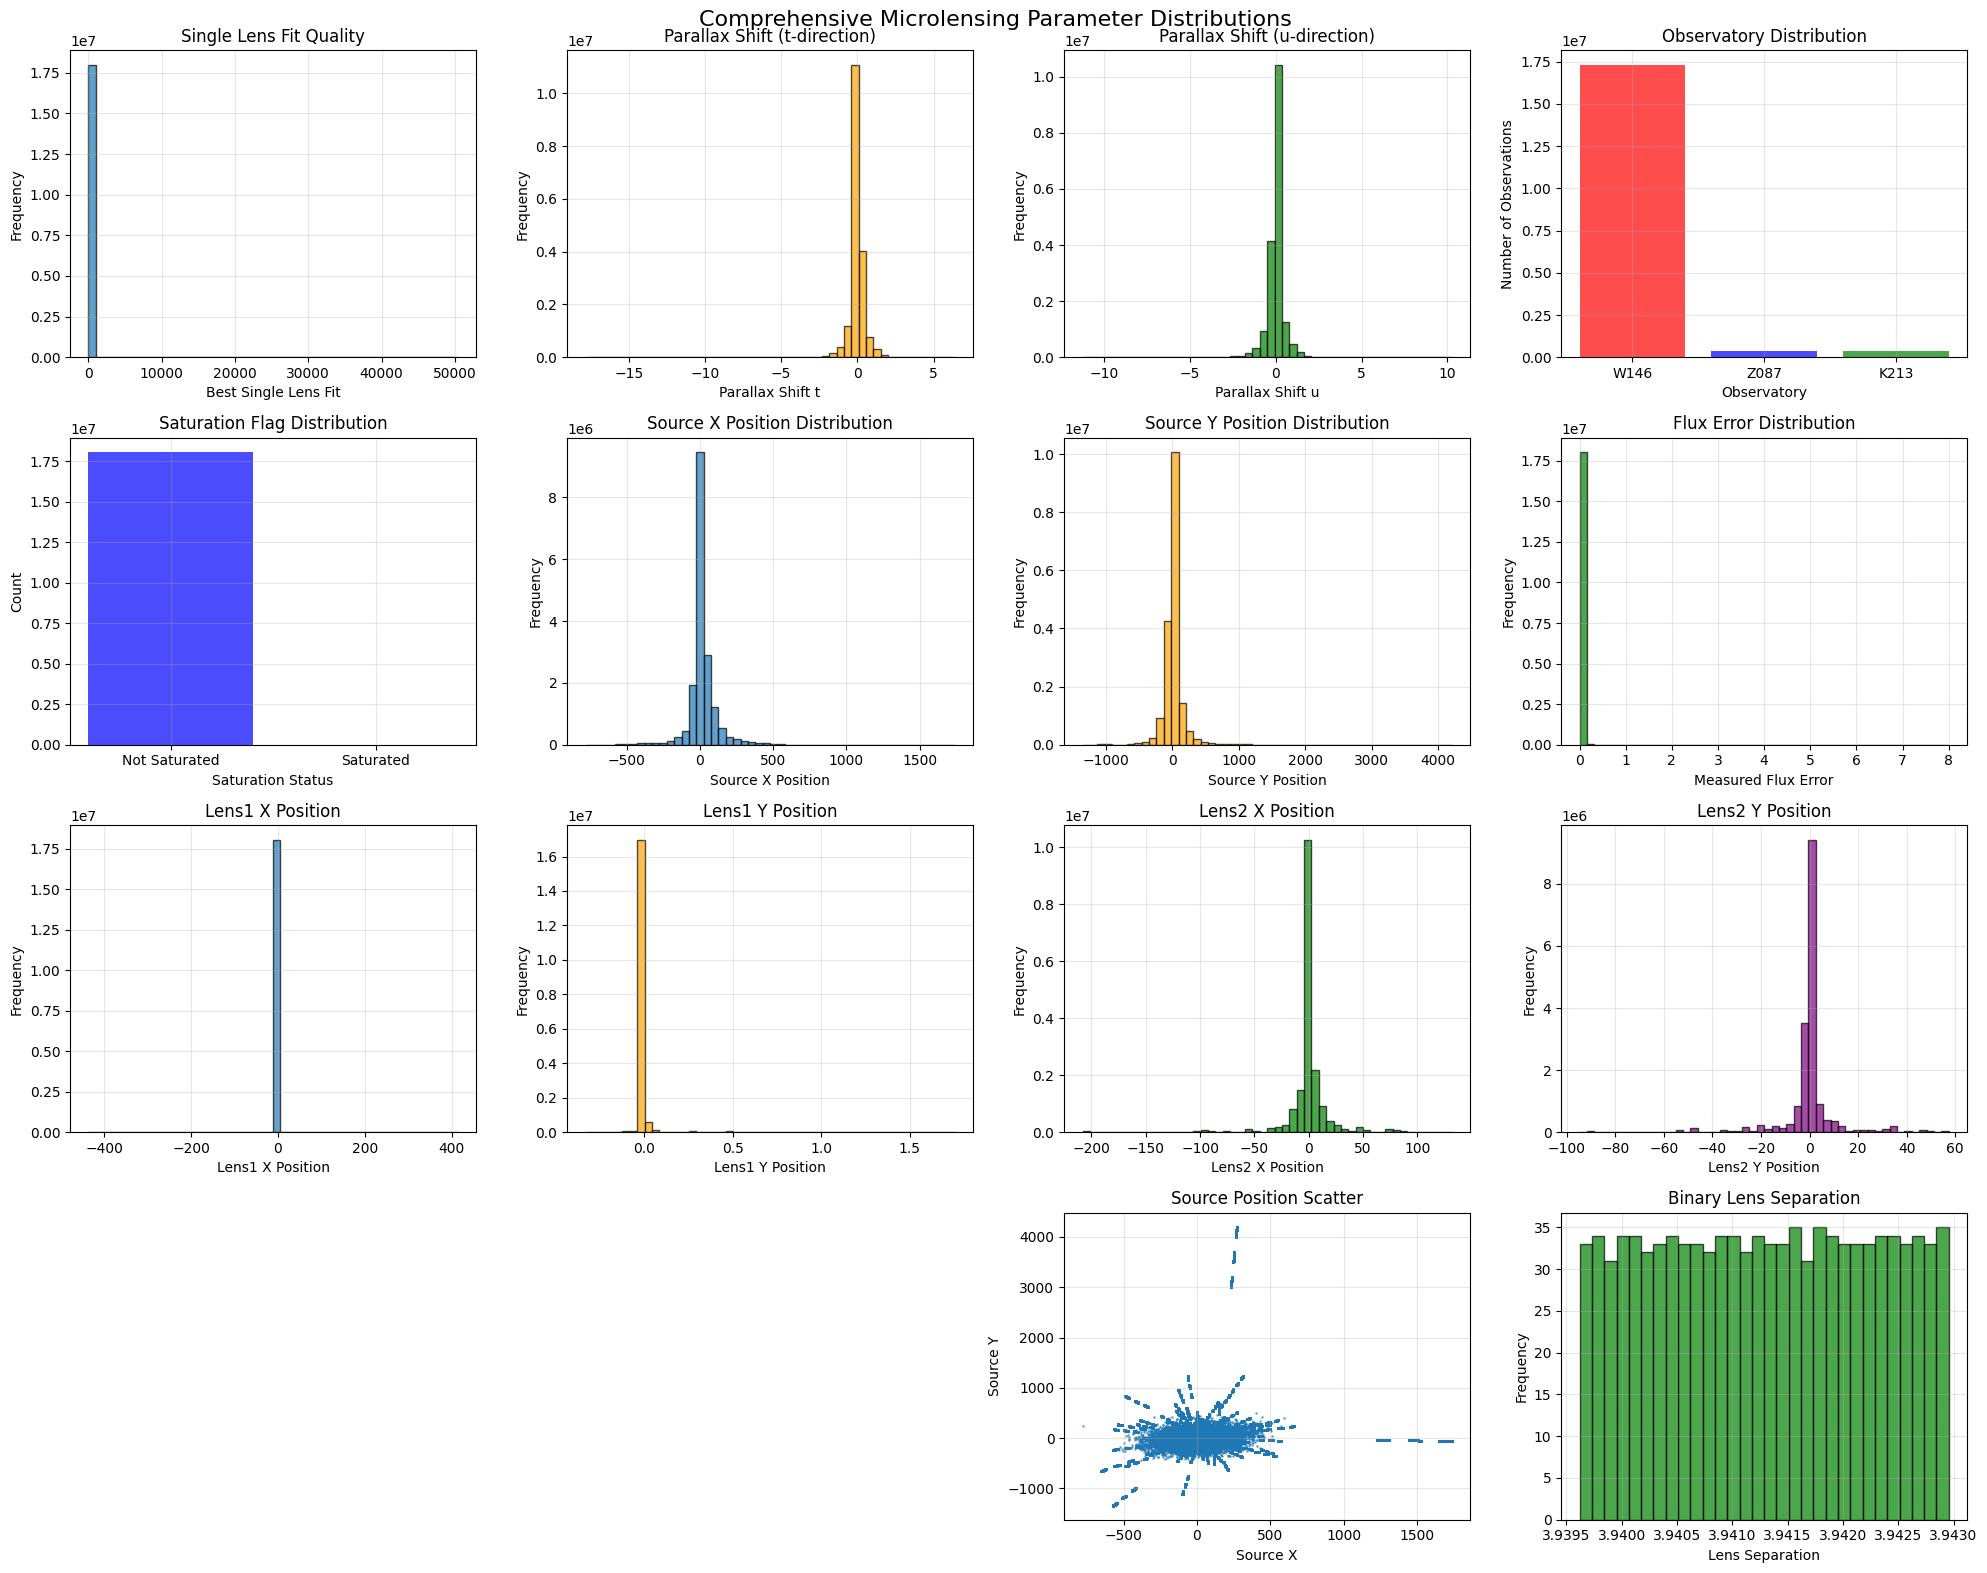


Analysis complete!


In [29]:
def main():
    """
    Main function to process all lightcurve files and generate plots
    """
    #print("Starting lightcurve data analysis...")
    #print("Looking for tar files in current directory...")
    #print("Files found:", [f for f in os.listdir('.') if f.endswith('.tar.gz')])
    
    # Process all tar files
    all_parameters = extract_and_process_tar_files()
    
    # Print summary statistics
    print_summary_statistics(all_parameters)
    
    # Generate distribution plots if we have data
    if any(len(params) > 0 for params in all_parameters.values()):
        plot_parameter_distributions(all_parameters)
        print("\nAnalysis complete!")
    else:
        print("\nNo lightcurve data found to analyze!")

if __name__ == "__main__":
    main()